In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Layer, MultiHeadAttention, LayerNormalization, Add, Reshape
from tensorflow.keras.applications import MobileNet, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
import kagglehub
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Téléchargement du dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Chemin des données :", path)

# Définition des répertoires
train_dir = os.path.join(path, 'chest_xray/train')
val_dir = os.path.join(path, 'chest_xray/val')
test_dir = os.path.join(path, 'chest_xray/test')

# Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Chemin des données : /kaggle/input/chest-xray-pneumonia


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [4]:
# --- Test generator ---
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Test samples: {test_generator.samples}, Classes: {test_generator.num_classes}")


Found 624 images belonging to 2 classes.
Test samples: 624, Classes: 2


In [5]:
folder_path = "/content/drive/MyDrive/chest_dl"

In [6]:
# --- Scan folder for models ---
model_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
print("Models found:")
for f in model_files:
    print(f"- {f}")


Models found:
- MobileNet.h5
- VGG16.h5
- ResNet-ViT_Hybrid.h5
- CNN_Custom.h5
- ResNet50.h5



Loading model: MobileNet.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 820ms/step
MobileNet.h5 -> Accuracy: 0.8926, AUC-ROC: 0.9696

Loading model: VGG16.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 598ms/step
VGG16.h5 -> Accuracy: 0.8990, AUC-ROC: 0.9569

Loading model: ResNet-ViT_Hybrid.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step
ResNet-ViT_Hybrid.h5 -> Accuracy: 0.6250, AUC-ROC: 0.5000

Loading model: CNN_Custom.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step
CNN_Custom.h5 -> Accuracy: 0.8670, AUC-ROC: 0.9361

Loading model: ResNet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step
ResNet50.h5 -> Accuracy: 0.8109, AUC-ROC: 0.8914


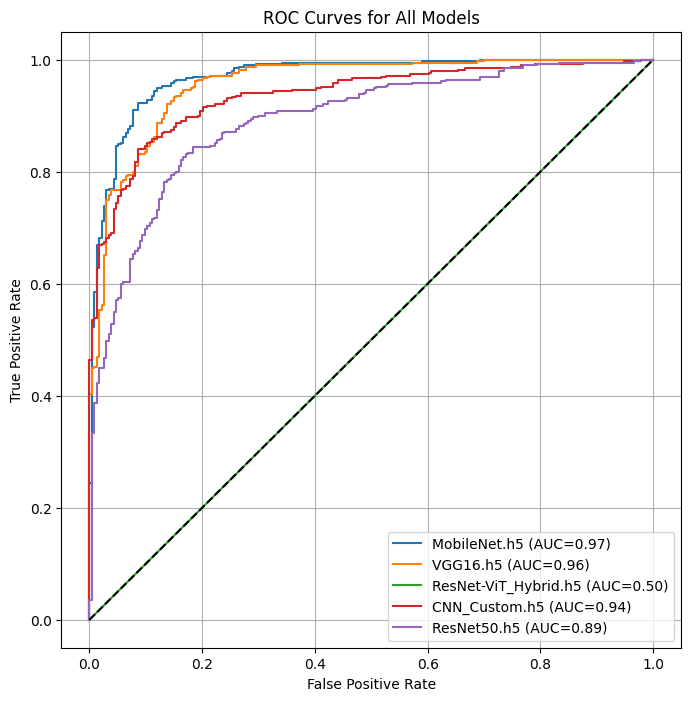

In [7]:
# --- Dictionary to store results ---
results = {}

plt.figure(figsize=(8,8))

for model_file in model_files:
    model_path = os.path.join(folder_path, model_file)
    print(f"\nLoading model: {model_file}")

    model = load_model(model_path)

    # --- Predict on test set ---
    y_probs = model.predict(test_generator)
    y_pred = (y_probs > 0.5).astype(int).flatten()
    y_true = test_generator.classes

    # --- Accuracy & AUC ---
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    print(f"{model_file} -> Accuracy: {acc:.4f}, AUC-ROC: {auc:.4f}")

    # --- Store results ---
    results[model_file] = {'accuracy': acc, 'auc': auc}

    # --- Plot ROC curve ---
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=f"{model_file} (AUC={auc:.2f})")

# --- Finalize plot ---
plt.plot([0,1],[0,1],'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()
